# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

### <center>  Final Project - Group #111 </center>

### <center>Forecasting COVID-19 cases using SARS-COV-2 titers in wastewater</center>



<center><b>Team:</b> V BHATIA, P BHATT, L BONDILI, R SOORI</center>


<hr style="height:2pt">

In [89]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import glob
import seaborn as sns
import matplotlib.dates as mdates
from pygam import LinearGAM, s
from datetime import datetime
import json 

import arviz as az
import pymc3 as pm
import patsy as pt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, matthews_corrcoef
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, MaxPool1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Classifiers
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from math import sqrt

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# DO NOT DELETE THIS CELL
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
MODELS_DIR = "models"
!mkdir -p $MODELS_DIR
        
def evaluate_model(model_name, y_test, y_predicted):
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    mape = mean_absolute_percentage_error(y_test, y_predicted)
    r_score = r2_score(y_test, y_predicted)
    corr_coeff = pearsonr(y_test, y_predicted)

    # Save model metrics
    metrics = {
        "Time": datetime.utcnow().isoformat(sep=' ', timespec='milliseconds'),
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape, 
        "Correlation Coeff": corr_coeff[0], 
        "R2 Score": r_score,
    }
    # Write to file
    with open(os.path.join(MODELS_DIR, model_name + "_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics))

In [5]:

# define my function for plotting my validation and loss history by epoch
# this function borrows heavily from the plot_history function provided
# in the Ex. 4 pre-lab for convolutional networks on Ed.

def plot_history(history_dict, title, test_eval=False,
                 loss_only=False, other_metric="accuracy"):
    """Plot training and validation loss and accuracy using keras history object
    """
    x_vals = np.arange(1, len(history_dict["loss"])+1)
    
    fig, ax = plt.subplots(1, 1 if loss_only else 2, figsize=(10, 4))

    plt.suptitle("{}".format(title), fontsize=16, y=1)
        
    if loss_only:
        
            ax.plot(x_vals, history_dict["loss"], "k--", label="train")
            ax.plot(x_vals, history_dict["val_loss"], "k-", label="validation")
            ax.set_xlabel("epoch", fontsize=12)
            ax.set_ylabel("loss", fontsize=12)
            ax.set_xticks(x_vals)
            ax.grid(":", alpha=0.4)
            ax.tick_params(labelsize=10)        
    
    else:
        
        for i, metric in enumerate(["loss", other_metric]):
            ax[i].plot(
                x_vals, history_dict[metric], "k--",
                label="train"
            )
            ax[i].plot(
                x_vals, history_dict["val_{}".format(metric)], "k-",
                label="validation"
            )
            ax[i].set_xlabel("epoch", fontsize=14)
            ax[i].set_ylabel(metric, fontsize=14)
            ax[i].set_xticks(x_vals)
            ax[i].grid(":", alpha=0.4)
            ax[i].tick_params(labelsize=10)

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [6]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

In [7]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [8]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [9]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

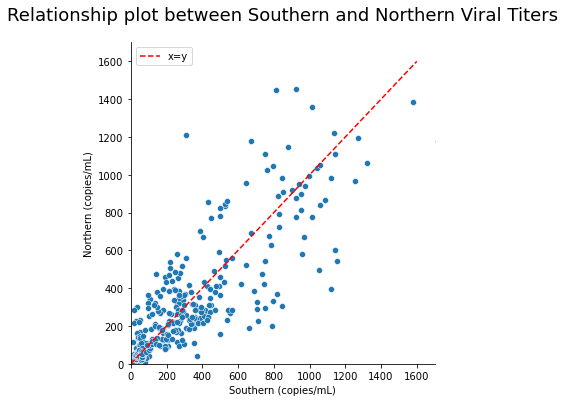

In [10]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

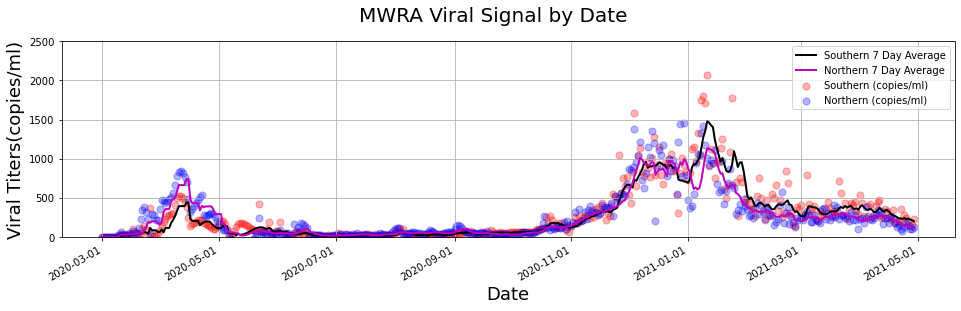

In [11]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [12]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [13]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [14]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [15]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


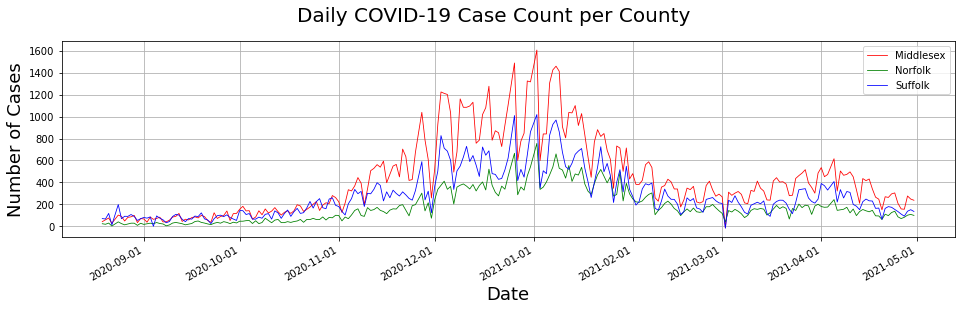

In [16]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [17]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135.0,16.0
1,2020-08-20,142.0,3.0
2,2020-08-21,221.0,3.0
3,2020-08-22,41.0,6.0
4,2020-08-24,340.0,13.0
...,...,...,...
245,2021-04-26,339.0,5.0
246,2021-04-27,329.0,1.0
247,2021-04-28,514.0,4.0
248,2021-04-29,507.0,5.0


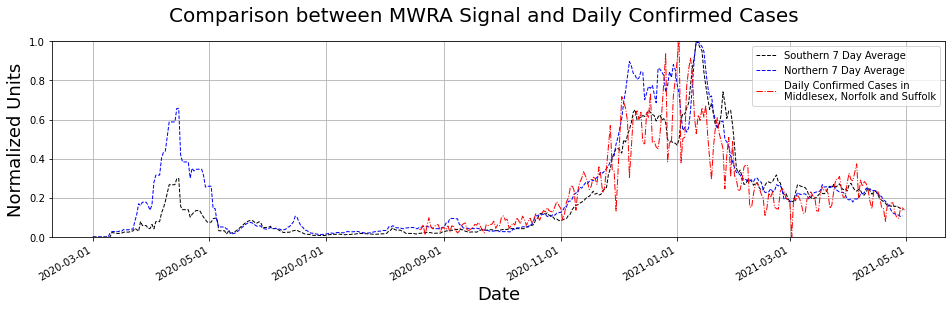

In [18]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [19]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern_Raw', 'Northern_Raw', 'Combined_Raw', 
                                              'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 
                                                'Southern_Variant', 'Northern_Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern_Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern_Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Combined_Raw'] = (row['Southern (copies/mL)'].to_list()[0] + row['Northern (copies/mL)'].to_list()[0]) / 2
        df_aligned.at[i, 'Southern_Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern_Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern_Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern_Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [20]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [21]:
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50.0,87.0,68.5,28.0,56.0,NaN,0,0,135.0,16.0,5.561524,0.659144
1,2020-08-20,43.068345,74.287119,58.677732,28.0,56.0,NaN,0,0,142.0,3.0,5.8499,0.123589
2,2020-08-21,35.0,60.0,47.5,35.0,61.0,NaN,0,0,221.0,3.0,9.104422,0.123589
3,2020-08-22,28.525255,49.594218,39.059737,35.0,61.0,NaN,0,0,41.0,6.0,1.689056,0.247179
4,2020-08-24,21.0,38.0,29.5,33.0,58.0,NaN,0,0,340.0,13.0,14.006802,0.535554


In [22]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases_Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths_Avg'] = df_aligned['Deaths'].rolling(window=7).mean()
# Also add average for southern and northern combined titers
df_aligned['Combined_Avg'] = df_aligned['Combined_Raw'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

In [23]:
# Finally normalize all values using MinMaxScaler
to_transform = ['Southern_Raw', 'Northern_Raw', 'Combined_Raw', 'Southern_Avg', 'Northern_Avg', 'Combined_Avg', 'Cases', 'Deaths', 'Cases_Avg', 'Deaths_Avg', 'Cases_per_100K', 'Deaths_per_100K'] 
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[to_transform] = scaler.fit_transform(df_aligned[to_transform])
df_aligned = df_scaled
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases_Avg,Deaths_Avg
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,0.400,0.038211,0.400,0.014857,0.204301
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,0.075,0.040284,0.075,0.014857,0.204301
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,0.075,0.063685,0.075,0.014857,0.204301
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,0.150,0.010367,0.150,0.014857,0.204301
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,0.325,0.098934,0.325,0.014857,0.204301


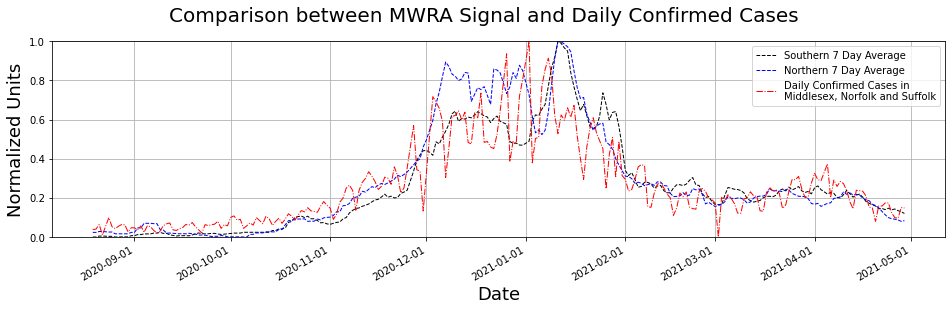

In [24]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases'].to_numpy(), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

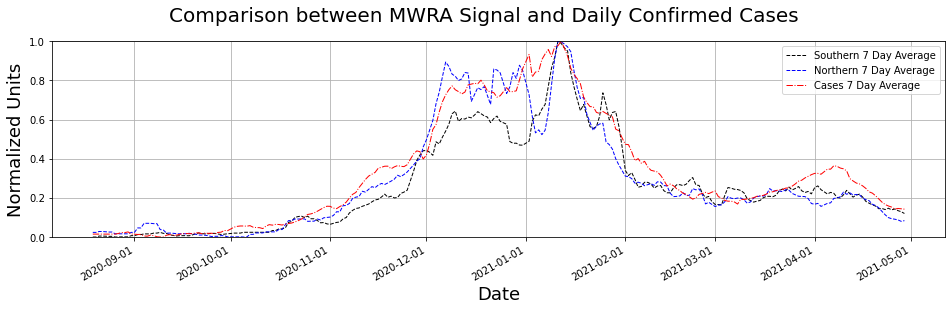

In [25]:
# Plot the timeseries data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Southern_Avg'].to_numpy(), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Northern_Avg'].to_numpy(), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

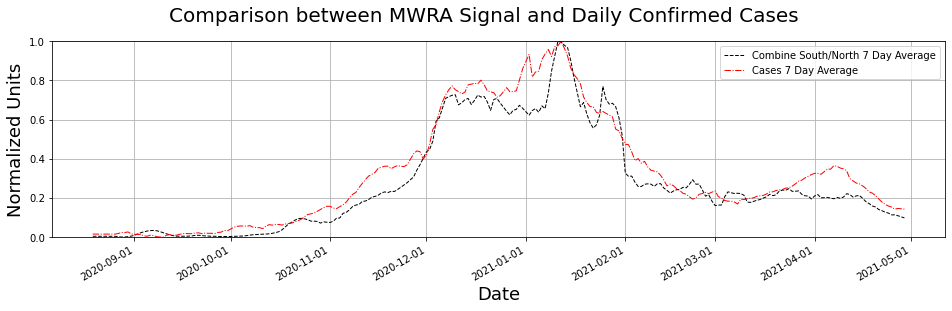

In [26]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], df_aligned['Combined_Avg'].to_numpy(), '--k', linewidth = 1,  label="Combine South/North 7 Day Average")
ax.plot(df_aligned['Date'], df_aligned['Cases_Avg'].to_numpy(), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

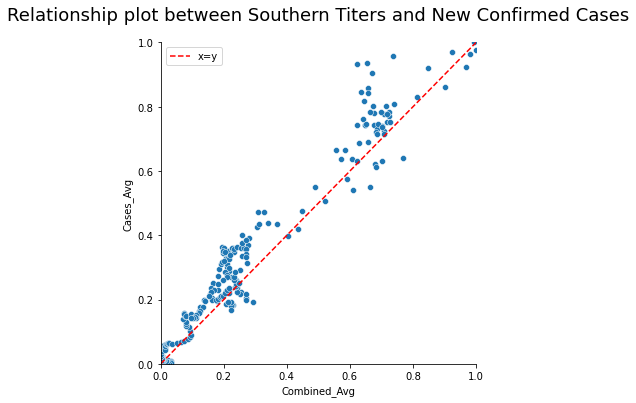

In [27]:
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Combined_Avg", y="Cases_Avg")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

In [28]:
# Create Lagged Dataset for Persistence Model
df_aligned['Cases_Avg(t-1)'] = df_aligned['Cases_Avg'].shift(1)
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Combined_Raw,Southern_Avg,Northern_Avg,Combined_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases_Avg,Deaths_Avg,Cases_Avg(t-1)
0,2020-08-19,0.008260,0.046154,0.017956,0.000000,0.023636,0.003742,0,0,0.038211,0.400,0.038211,0.400,0.014857,0.204301,NaN
1,2020-08-20,0.006413,0.037264,0.013434,0.000000,0.023636,0.003742,0,0,0.040284,0.075,0.040284,0.075,0.014857,0.204301,0.014857
2,2020-08-21,0.004263,0.027273,0.008287,0.004834,0.028182,0.003742,0,0,0.063685,0.075,0.063685,0.075,0.014857,0.204301,0.014857
3,2020-08-22,0.002538,0.019996,0.004401,0.004834,0.028182,0.003742,0,0,0.010367,0.150,0.010367,0.150,0.014857,0.204301,0.014857
4,2020-08-24,0.000533,0.011888,0.000000,0.003453,0.025455,0.003742,0,0,0.098934,0.325,0.098934,0.325,0.014857,0.204301,0.014857


# Modeling


In [29]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model


<FONT color='red'> What is a Persistence model?
</FONT>

In [30]:
# Create training and test labels for persistence model
X_train, y_train = df_train['Cases_Avg(t-1)'], df_train['Cases_Avg'],
X_test, y_test = df_test['Cases_Avg(t-1)'], df_test['Cases_Avg']

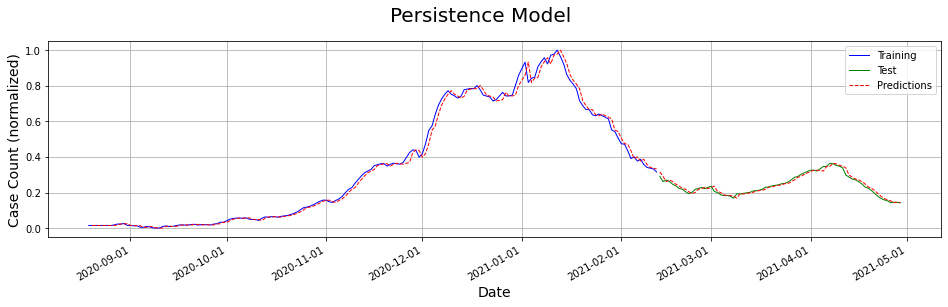

In [31]:
# plot persistence predictions and expected results
# The train_X and test_X are the predictions for the persistence model
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_train['Date'], X_train, '--r', linewidth = 1)
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], X_test, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [32]:
# Evaluated Model
# For persistence X_test values are the predictions
evaluate_model("Persistence", y_test, X_test)

<FONT color='red'> INTERPRETATION:
</FONT>

# Multiple Linear Regression

In [33]:
# Linear Regression Model
# Create training and test features with intercepts
X_train = df_train[['Southern_Avg', 'Northern_Avg']].astype('float')
X_train = sm.add_constant(X_train) # adding a constant
y_train = df_train['Cases_Avg'].astype('float')

X_test = df_test[['Southern_Avg', 'Northern_Avg']].astype('float')
X_test = sm.add_constant(X_test) # adding a constant
y_test = df_test['Cases_Avg'].astype('float')

# Fit the model
model_lm1 = sm.OLS(y_train, X_train).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Cases_Avg   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     2131.
Date:                Sun, 09 May 2021   Prob (F-statistic):          1.34e-121
Time:                        05:06:30   Log-Likelihood:                 233.85
No. Observations:                 174   AIC:                            -461.7
Df Residuals:                     171   BIC:                            -452.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0291      0.007      4.198      0.000       0.015       0.043
Southern_Avg     0.6311      0.053     11.824      0.000       0.526       0.736
Northern_Avg     0.4551      0.047      9.644      0.000       0.362       0.548
==============================================================================
Omnibus:                       44.465   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.338
Skew:                           1.106   Prob(JB):                     2.20e-23
Kurtosis:                       6.082   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

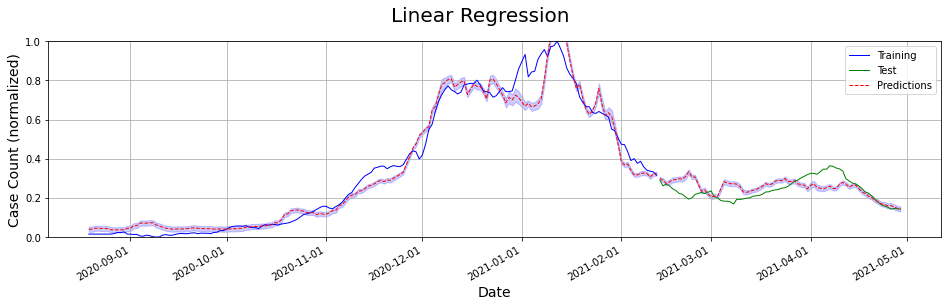

In [34]:
# Get predictions
train_preds = model_lm1.get_prediction(X_train).summary_frame()
test_preds = model_lm1.get_prediction(X_test).summary_frame()

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                train_preds['mean_ci_upper'], color='b', alpha=.2)

ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Linear Regression', fontsize=20, y=1.00)
fig.show()

In [35]:
# Evaluate Model
evaluate_model("Linear", y_test, test_preds['mean'])

<FONT color='red'> INTERPRETATION:
</FONT>

# Polynomal Regression

In [36]:
def generate_poly_features(x, degree):
    poly = PolynomialFeatures(degree=degree)
    xp = poly.fit_transform(x)
    return xp

def generate_polynomial_model(x, y, degree):
    xp = generate_poly_features(x, degree)
    return xp, sm.OLS(y, xp).fit()

/usr/share/anaconda3/lib/python3.8/site-packages/statsmodels/regression/_prediction.py:57: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean + self.var_resid)
/usr/share/anaconda3/lib/python3.8/site-packages/statsmodels/regression/_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


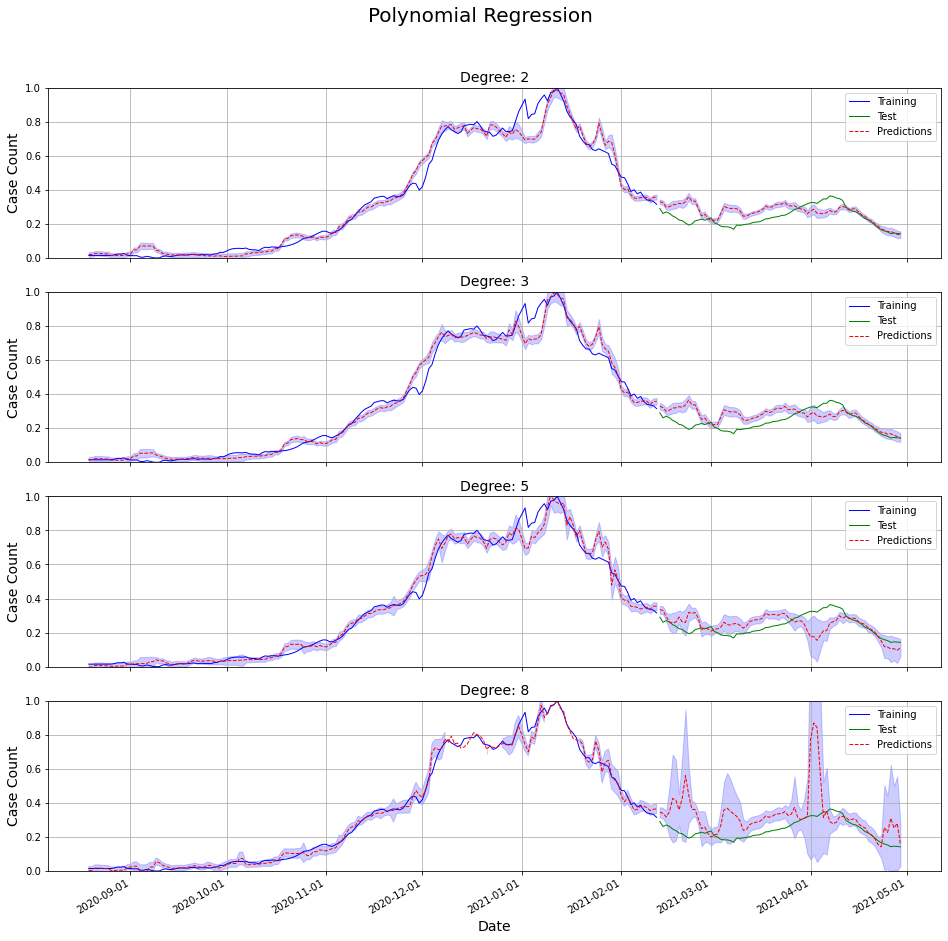

In [37]:
#your code here
poly_models = list()
degrees = [2,3,5,8]

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 4, ncols = 1, sharey=True, figsize=(16,16))
ax = ax.flatten()

for i, degree in enumerate(degrees):

    # Generate model
    y_train = df_train['Cases_Avg'].astype('float')
    X_train , model = generate_polynomial_model(df_train[['Southern_Avg', 'Northern_Avg']].astype('float'), 
                                                y_train, 
                                                degree)
    
    # Add model to list
    poly_models.append(model)
    
    # Generate x_test
    y_test = df_test['Cases_Avg'].astype('float')
    X_test = generate_poly_features(df_test[['Southern_Avg', 'Northern_Avg']].astype('float'), degree)

    # Generate predictions
    train_preds = model.get_prediction(X_train).summary_frame()
    test_preds = model.get_prediction(X_test).summary_frame()
    
    ax[i].plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
    ax[i].plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
    ax[i].plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
    ax[i].plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

    # CI for the predection at each x value, i.e. the line itself
    ax[i].fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                    train_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                    test_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].grid(True)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_title(f'Degree: {degree}', fontsize=14)
    ax[i].set_ylabel(f'Case Count', fontsize = 14)
    ax[i].set_xlabel('Date', fontsize = 14)
    ax[i].set_ylim([0,1])
    
    # Evaluate Model
    evaluate_model(f"Polynomial Order: {degree}", y_test, test_preds['mean'])
    
fig.autofmt_xdate()
fig.suptitle('Polynomial Regression', fontsize=20, y=0.95)
fig.show()

<FONT color='red'> INTERPRETATION:
</FONT>

# Generalized Linear Model with Poisson Regression

$\theta = exp(\beta_0 + \beta_1 X_1 + \beta_2 X_2)$


$Y_{count} \sim Poisson(\theta)$

In [38]:
x1 = df_aligned['Southern_Avg']
x2 = df_aligned['Northern_Avg']
y_obs = df_aligned['Cases_Avg']

In [39]:
with pm.Model() as model_glm_poisson:

    # Define Prior Distributions (Betas)
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_Southern", mu=0, sigma=10)
    b2 = pm.Normal("b2_Northern", mu=0, sigma=10)
    
    # Deterministic variable
    # define linear model and exp link function
    #theta = (b0 + b1*x1 + b2*x2)
    theta = pm.Deterministic('theta',pm.math.exp(b0 + b1*x1 + b2*x2))

    # Likelihood function Y ~ Poisson(theta)
    ## Define Poisson likelihood
    Y_obs = pm.Poisson("Y_obs", mu=theta, observed=y_obs)

In [40]:
#pm.model_to_graphviz(model_glm_poisson)

In [41]:

np.seterr(divide='ignore') # Suppress divide by zero warning
with model_glm_poisson:
    print(f'Starting MCMC process')
    nsamples = 20000 # number of samples to keep
    burnin = 4000 # burnin period
    trace = pm.sample(nsamples, tune=burnin, target_accept=0.9, cores=4, random_seed = 109, return_inferencedata=False) # return_inferencedata = False to suppress warning 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Starting MCMC process


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2_Northern, b1_Southern, b0_intercept]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 57 seconds.
There were 1234 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2419 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1191 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1282 divergences after tuning. Increase `target_accept` or reparameterize.


DONE


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


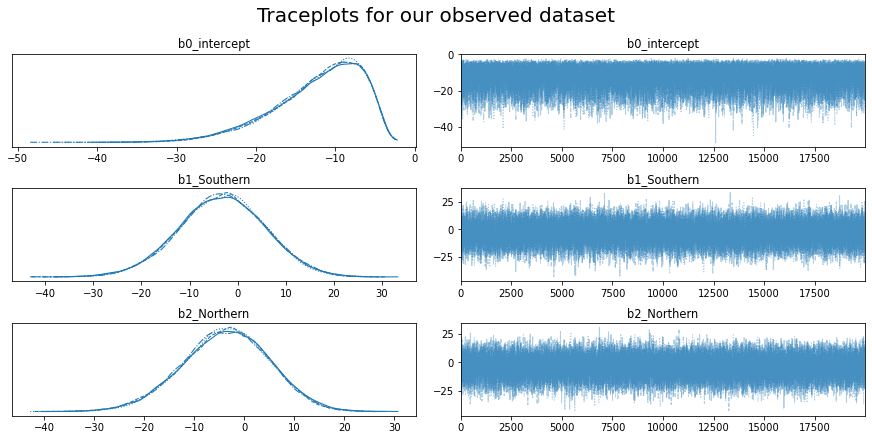

In [42]:
# Plot only mu0, tau0 and beta1,2,3
varnames = ['b0_intercept', 'b1_Southern', 'b2_Northern']
title = f'Traceplots for our observed dataset'
az.plot_trace(trace, var_names = varnames, compact=True, divergences = None);
plt.suptitle( title, fontsize=20 )
plt.show()

In [43]:
print(f'R-hat values for hidden parameters')
results = az.summary(
    trace, 
    var_names = varnames
)
display(results)

R-hat values for hidden parameters


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_intercept,-12.188,5.577,-22.712,-3.702,0.042,0.030,20551.0,24714.0,1.0
b1_Southern,-3.268,8.995,-20.320,13.492,0.059,0.041,23582.0,31281.0,1.0
b2_Northern,-3.724,8.721,-20.324,12.386,0.055,0.039,25329.0,32356.0,1.0


/usr/share/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

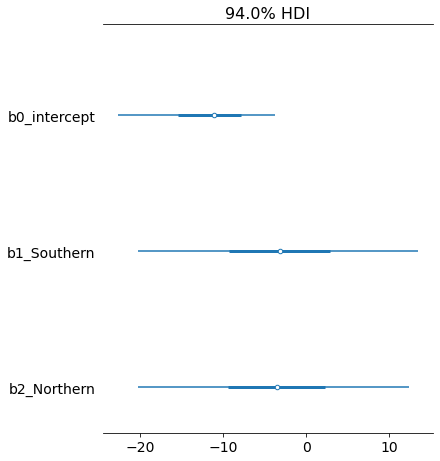

In [44]:
az.plot_forest(trace, var_names = varnames, combined=True)

In [45]:
def model_glm_predict(trace, x):
    beta0 = trace['b0_intercept']
    beta1 = trace['b1_Southern']
    beta2 = trace['b2_Northern']
    
    # Create the prediction model
    x1 = x[0]
    x2 = x[1]
    
    # Theta
    m_theta = np.outer(beta0, np.ones(shape=(len(x1),))) +\
                np.outer(beta1, x1) +\
                np.outer(beta2, x2)
    
    m_mus = np.exp(m_theta)
    m_y = np.mean(m_mus, axis=0)
    
    # Pick most frequent value
    return m_y

mus = model_glm_predict(trace, [x1,x2])

<FONT color='red'> INTERPRETATION:
</FONT>

# PyGAM

In [46]:
X_train, y_train = df_train[['Southern_Avg', 'Northern_Avg']].astype('float'), df_train['Cases_Avg'].astype('float')
X_test, y_test = df_test[['Southern_Avg', 'Northern_Avg']].astype('float'), df_test['Cases_Avg'].astype('float')

#formula = s(0) + s(1)
#model_gam = LinearGAM(formula).fit(X_train, y_train)

In [47]:

# Create our model, we'll use grid search to find best smoothing parameter for each feature using a randomized 
# search grid as suggested by pyGAM docs
# https://readthedocs.org/projects/pygam/downloads/pdf/latest/
n_features = 2 # Southern_Avg and Northern_Avg
lams = 10 ** (np.random.rand(100, n_features) * 6 - 3)

gam = LinearGAM(s(0) + s(1))
gam.gridsearch(X_train.to_numpy(), y_train.to_numpy(), lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

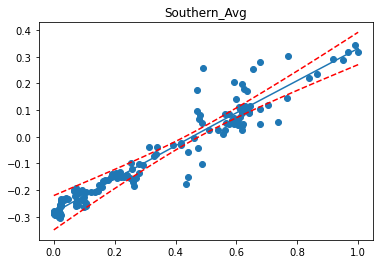

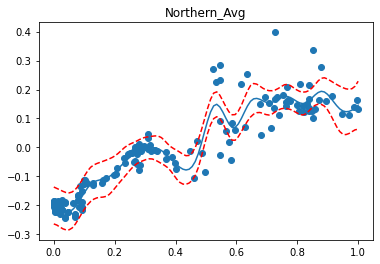

In [48]:
#your code here
res = gam.deviance_residuals(X_train,y_train)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term=i, X=X_train, width=0.95)
    plt.figure()
    plt.scatter(X_train.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X_train.columns.values[term.feature])
    plt.show()

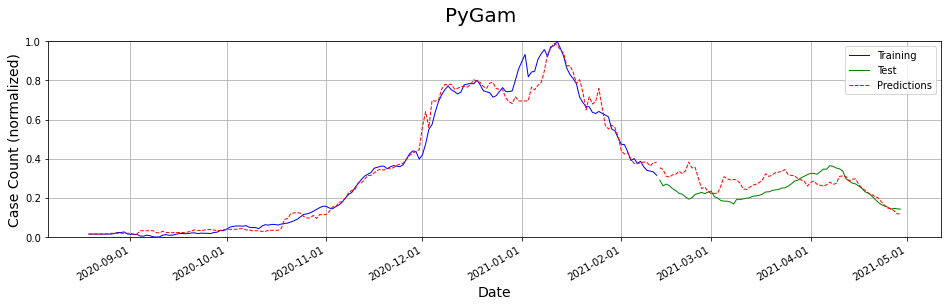

In [49]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], gam.predict(X_train), '--r', linewidth = 1)
ax.plot(df_test['Date'], gam.predict(X_test), '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
#ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
#                train_preds['mean_ci_upper'], color='b', alpha=.2)

#ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
#                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('PyGam', fontsize=20, y=1.00)
fig.show()

In [50]:
# Evaluate Model
evaluate_model("GAM", y_test, gam.predict(X_test))

<FONT color='red'> INTERPRETATION:
</FONT>

# NEURAL NETWORKS

Lets build different Neural Network architectures, train the models, validate them and store the metrics. 

In [51]:
df_train['Cases_Avg(t-1)'] = df_train['Cases_Avg(t-1)'].fillna(0)
df_test['Cases_Avg(t-1)'] = df_test['Cases_Avg(t-1)'].fillna(0)

X_train = df_train[['Southern_Avg', 'Northern_Avg', 'Cases_Avg(t-1)']].astype('float').to_numpy()
y_train = df_train['Cases_Avg'].astype('float').to_numpy()

X_test = df_test[['Southern_Avg', 'Northern_Avg', 'Cases_Avg(t-1)']].astype('float').to_numpy()
y_test = df_test['Cases_Avg'].astype('float').to_numpy()

In [52]:
# GRUs and LSTMs expect a 3D input, so converting the train and test data

def convert_dataset_3d (X, y, time_steps=1):
    X_values, y_values = [], []
    for i in range(len(X) - time_steps):
        X_values.append(X[i: i+time_steps, :])
        y_values.append(y[i+time_steps])
    return np.array(X_values), np.array(y_values)

TIME_STEPS = 7

X_train, y_train = convert_dataset_3d(X_train, y_train.reshape(-1,1), TIME_STEPS)
X_test, y_test = convert_dataset_3d(X_test, y_test.reshape(-1,1), TIME_STEPS)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (167, 7, 3)
y_train.shape:  (167, 1)
X_test.shape:  (68, 7, 3)
y_test.shape:  (68, 1)


In [53]:
# Hyperparameters
n_units_1 = 64
n_units_2 = 32

drop_rate = 0.1
batch_size = 8
epochs = 50
validation_split = 0.2
verbose = 1
optimizer = Adam(learning_rate = 0.0006)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Conv-1D Model

In [54]:
tf.keras.backend.clear_session()

# Define simple 1D CNN model
model_cnn = Sequential()

model_cnn.add(Conv1D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu', 
               input_shape=([X_train.shape[1], X_train.shape[2]])))
#model_cnn.add(MaxPool1D(pool_size = 2))
model_cnn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu'))

model_cnn.add(GRU(128, return_sequences = True, recurrent_dropout = 0.3))
model_cnn.add(GRU(64, recurrent_dropout = 0.3))

#model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation = 'relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(32, activation = 'relu'))
#model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            24704     
_________________________________________________________________
gru (GRU)                    (None, 3, 128)            99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [55]:
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_cnn.load_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "rb") as filehandler:
        history_cnn = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_cnn = history_cnn.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_cnn.pkl'), "wb") as filehandler:
        pickle.dump(history_cnn, filehandler)
    # save model weights for future use
    model_cnn.save_weights(os.path.join(MODELS_DIR,'model_cnn.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 6s 54ms/step - loss: 0.1296 - val_loss: 0.2125
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0936 - val_loss: 0.0498
Epoch 3/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0281 - val_loss: 0.0133
Epoch 4/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0131 - val_loss: 0.0373
Epoch 5/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0140 - val_loss: 0.0188
Epoch 6/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0166 - val_loss: 0.0210
Epoch 7/50
17/17 [==============================] - 0s 21ms/step - loss: 0.0079 - val_loss: 0.0181
Epoch 8/50
17/17 [==============================] - 0s 25ms/step - loss: 0.0112 - val_loss: 0.0212

...model weights and training history successfully saved to file.



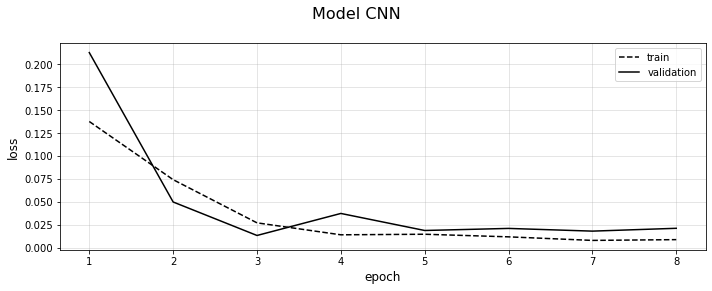

In [56]:
plot_history(history_cnn, "Model CNN", loss_only=True)

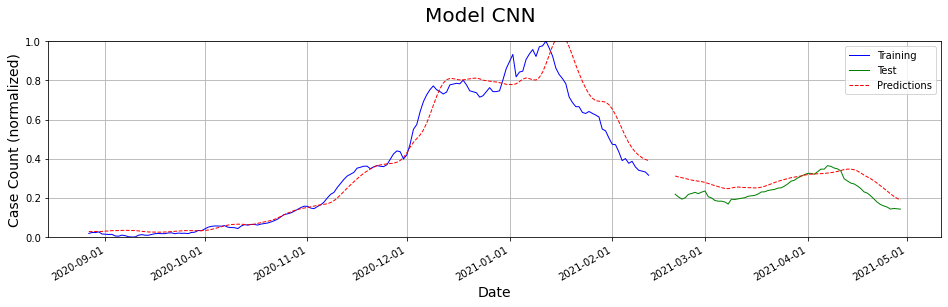

In [58]:
train_predictions = model_cnn.predict(X_train)
test_preds = model_cnn.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model CNN', fontsize=20, y=1.00)
fig.show()

In [59]:
# Evalute Model
evaluate_model("CNN", y_test.flatten(), test_preds.flatten())

# GRU Model

GRU's are similar to RNN architecture, but with the addition of two new gates:
- Reset Gate
- Update Gate

RESET gate is similar to skip connection which allows us to "forget" hidden weights, UPDATE gate allows to update weights in our model. 

GRU helps reduce the vanishing gradient problem prevalent in RNN

In [60]:
# Define GRU Model
model_gru = Sequential()
model_gru.add(tf.keras.layers.GRU(n_units_1, 
                                  return_sequences = True, 
                                  input_shape = [X_train.shape[1], X_train.shape[2]], 
                                  dropout = 0.0, recurrent_dropout = 0.3))
model_gru.add(tf.keras.layers.GRU(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_gru.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile model
model_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7, 64)             13248     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,689
Trainable params: 22,689
Non-trainable params: 0
_________________________________________________________________


In [61]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_gru.load_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "rb") as filehandler:
        history_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_gru = model_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_gru = history_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_gru, filehandler)
    # save model weights for future use
    model_gru.save_weights(os.path.join(MODELS_DIR,'model_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 60ms/step - loss: 0.2533 - val_loss: 0.3233
Epoch 2/50
17/17 [==============================] - 1s 36ms/step - loss: 0.1194 - val_loss: 0.1939
Epoch 3/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0820 - val_loss: 0.0984
Epoch 4/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0565 - val_loss: 0.0404
Epoch 5/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0320 - val_loss: 0.0146
Epoch 6/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0219 - val_loss: 0.0078
Epoch 7/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0133 - val_loss: 0.0081
Epoch 8/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 9/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0082 - val_loss: 0.0100
Epoch 10/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 11/

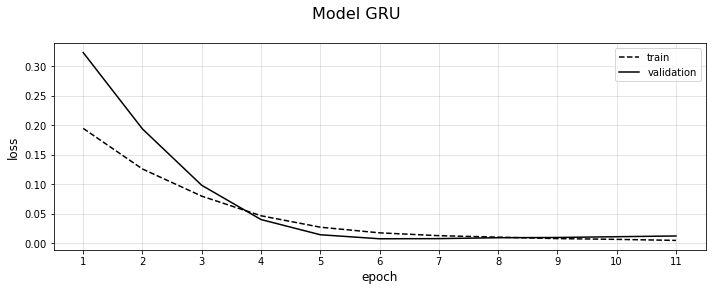

In [62]:
plot_history(history_gru, "Model GRU", loss_only=True)

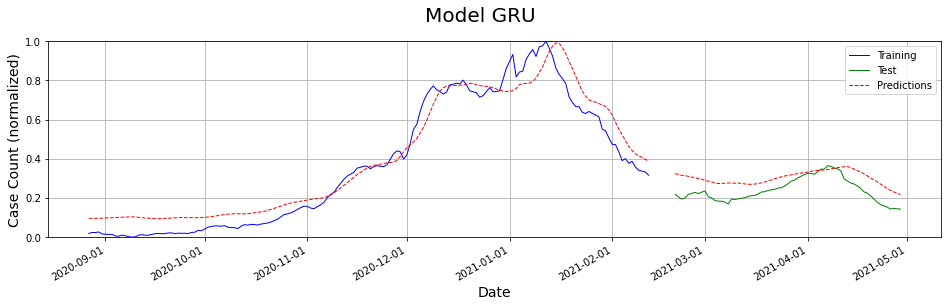

In [63]:
train_predictions = model_gru.predict(X_train)
test_preds = model_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model GRU', fontsize=20, y=1.00)
fig.show()

In [64]:
# Evalute Model
evaluate_model("GRU", y_test.flatten(), test_preds.flatten())

# LSTM 

LSTM has three gates
* Input gate
* Output gate
* Forget gate

LSTM is more accurate on dataset using longer sequences.

In [65]:
# Define LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(n_units_1, return_sequences = True, 
                    input_shape = [X_train.shape[1], X_train.shape[2]], 
                    dropout = 0.0, recurrent_dropout = 0.3))
#model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(LSTM(n_units_2, dropout = 0.0, recurrent_dropout = 0.3))
model_lstm.add(Dense(1, activation='linear'))

# Compile model
model_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [66]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_lstm.load_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "rb") as filehandler:
        history_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_lstm = history_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_lstm, filehandler)
    # save model weights for future use
    model_lstm.save_weights(os.path.join(MODELS_DIR,'model_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 4s 60ms/step - loss: 0.2000 - val_loss: 0.3755
Epoch 2/50
17/17 [==============================] - 1s 38ms/step - loss: 0.1372 - val_loss: 0.2728
Epoch 3/50
17/17 [==============================] - 1s 38ms/step - loss: 0.1054 - val_loss: 0.1860
Epoch 4/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0858 - val_loss: 0.1090
Epoch 5/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0567 - val_loss: 0.0522
Epoch 6/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0339 - val_loss: 0.0195
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 8/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0092 - val_loss: 0.0164
Epoch 9/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0068 - val_loss: 0.0208
Epoch 10/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0067 - val_loss: 0.0238
Epoch 11/

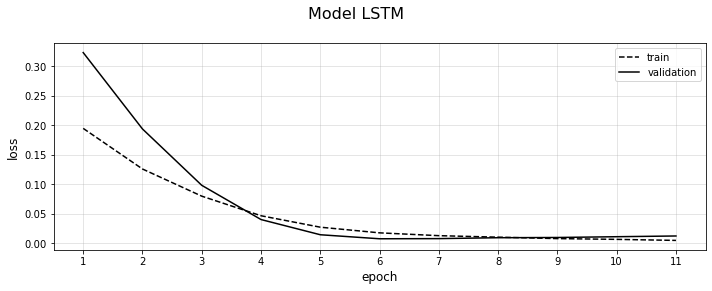

In [67]:
plot_history(history_gru, "Model LSTM", loss_only=True)

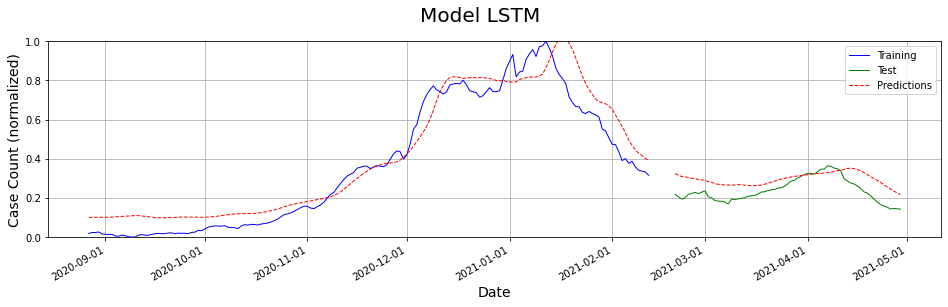

In [68]:
train_predictions = model_lstm.predict(X_train)
test_preds = model_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model LSTM', fontsize=20, y=1.00)
fig.show()

In [69]:
# Evalute Model
evaluate_model("LSTM", y_test.flatten(), test_preds.flatten())

# BiGRU

**BiDirectional GRU** consists of two separate gated recurrent units. One processing the sequence from left to right, the other processes that same sequence but in reverse, from right to left. The output of the two units are then concatenated together and fed to the next layer of the network. 

This allows the network to learn from forward sequences and by reversing the sequence and learning them backwards.

In [70]:
# Bidirectional GRU
model_bi_gru = Sequential()
model_bi_gru.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_gru.add(Bidirectional(GRU(n_units_1, return_sequences = True)))
model_bi_gru.add(tf.keras.layers.Dropout(drop_rate))
model_bi_gru.add(Bidirectional(GRU(n_units_2)))
model_bi_gru.add(Dense(1, activation='linear'))

# Compile model
model_bi_gru.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 7, 128)            26496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 57,665
Trainable params: 57,665
Non-trainable params: 0
_________________________________________________________________


In [71]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_gru.load_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "rb") as filehandler:
        history_bi_gru = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_gru = model_bi_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_gru = history_bi_gru.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_gru.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_gru, filehandler)
    # save model weights for future use
    model_bi_gru.save_weights(os.path.join(MODELS_DIR,'model_bi_gru.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 61ms/step - loss: 0.1233 - val_loss: 0.0631
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0379 - val_loss: 0.0104
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0191
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0255
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0222
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0213
Epoch 7/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0240

...model weights and training history successfully saved to file.



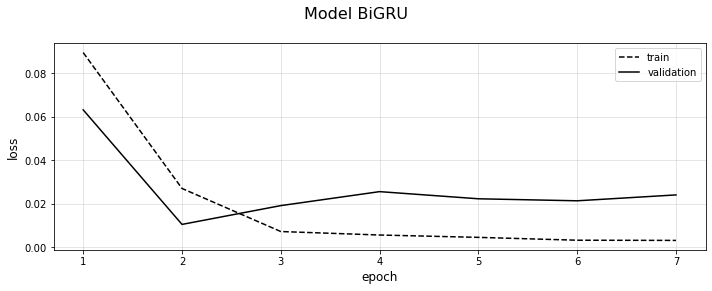

In [72]:
plot_history(history_bi_gru, "Model BiGRU", loss_only=True)

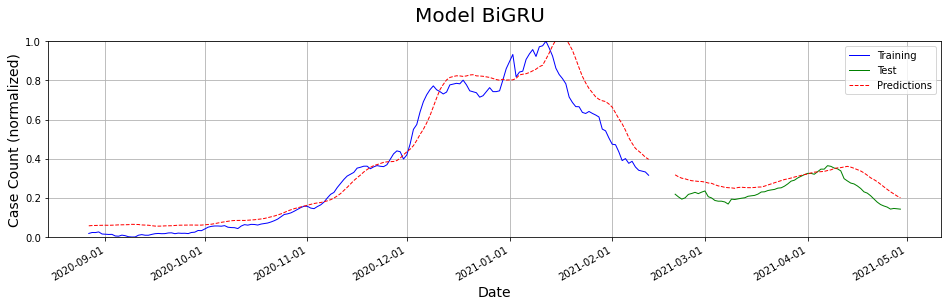

In [73]:
train_predictions = model_bi_gru.predict(X_train)
test_preds = model_bi_gru.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiGRU', fontsize=20, y=1.00)
fig.show()

In [74]:
# Evalute Model
evaluate_model("BiGRU", y_test.flatten(), test_preds.flatten())

# Bi LSTM

In [75]:
# Define Bidirectional LSTM Model
model_bi_lstm = Sequential()
model_bi_lstm.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_lstm.add(Bidirectional(LSTM(n_units_1, return_sequences = True)))
model_bi_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_bi_lstm.add(Bidirectional(LSTM(n_units_2)))
model_bi_lstm.add(Dense(1, activation='linear'))

# Compile model
model_bi_lstm.compile(optimizer=Adam(learning_rate = 0.0001), loss='mse')

model_bi_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 7, 128)            34816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 76,097
Trainable params: 76,097
Non-trainable params: 0
_________________________________________________________________


In [76]:
#2.5
train = True

# Train model if use_saved_model=False, else load saved model
if not train:
    #load the model weights
    model_bi_lstm.load_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "rb") as filehandler:
        history_bi_lstm = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_bi_lstm = model_bi_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

    # extract history dict from model history object
    history_bi_lstm = history_bi_lstm.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists(MODELS_DIR):
        os.mkdir(MODELS_DIR)
    # save fitted training history dict using pickle
    with open(os.path.join(MODELS_DIR,'model_bi_lstm.pkl'), "wb") as filehandler:
        pickle.dump(history_bi_lstm, filehandler)
    # save model weights for future use
    model_bi_lstm.save_weights(os.path.join(MODELS_DIR,'model_bi_lstm.h5'))
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Epoch 1/50
17/17 [==============================] - 5s 70ms/step - loss: 0.1695 - val_loss: 0.1783
Epoch 2/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0729 - val_loss: 0.0601
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0337 - val_loss: 0.0112
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0141
Epoch 5/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0271
Epoch 6/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0263
Epoch 7/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0245
Epoch 8/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0262

...model weights and training history successfully saved to file.



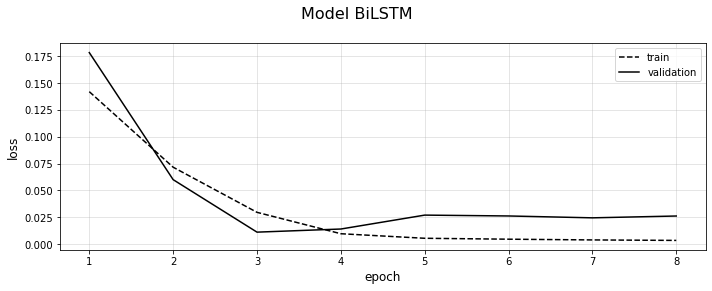

In [77]:
plot_history(history_bi_lstm, "Model BiLSTM", loss_only=True)

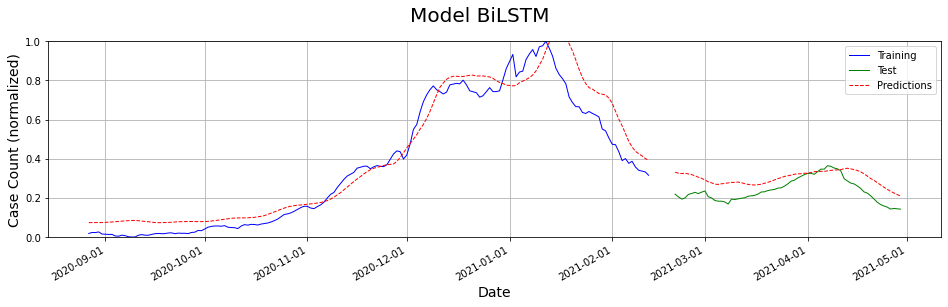

In [78]:
train_predictions = model_bi_lstm.predict(X_train)
test_preds = model_bi_lstm.predict(X_test)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'][TIME_STEPS:], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'][TIME_STEPS:], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'][TIME_STEPS:], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'][TIME_STEPS:], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model BiLSTM', fontsize=20, y=1.00)
fig.show()

In [79]:
# Evalute Model
evaluate_model("BiLSTM", y_test.flatten(), test_preds.flatten())

### Interpretation of Neural Network Models

* All the neural network models (GRU, LSTM, CNN, Bidirectional models) provided very similar results


* The predicted values are lagged by 5-6 days when compared to the train and test set

# XGBoost

In [80]:
xg_train = df_train[['Date', 'Southern_Avg', 'Northern_Avg', "Cases_Avg","Cases_Avg(t-1)"]]
xg_test = df_test[['Date', 'Southern_Avg', 'Northern_Avg', "Cases_Avg","Cases_Avg(t-1)"]]

In [81]:
#Removed day of year from this df

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['Southern_Avg']=df['Southern_Avg'].astype(int)
    df['Northern_Avg']=df['Northern_Avg'].astype(int)
    df['Cases_Avg(t-1)']=df['Cases_Avg(t-1)'].astype(float)


    
    X = df[['Southern_Avg','Northern_Avg','dayofweek','month','dayofmonth','weekofyear',"Cases_Avg(t-1)"]]
    if label:
        y = df[label]
        return X, y
    return X

In [82]:
X_train_xg, y_train_xg = create_features(xg_train, label='Cases_Avg')
X_test_xg, y_test_xg = create_features(xg_test, label='Cases_Avg')

<ipython-input-81-c591d3608bd5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['Date'].dt.dayofweek
<ipython-input-81-c591d3608bd5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.month
<ipython-input-81-c591d3608bd5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [83]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_xg, y_train_xg,
        eval_set=[(X_train_xg, y_train_xg), (X_test_xg, y_test_xg)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:0.25161	validation_1-rmse:0.20832
[1]	validation_0-rmse:0.17945	validation_1-rmse:0.15779
[2]	validation_0-rmse:0.12838	validation_1-rmse:0.11298
[3]	validation_0-rmse:0.09229	validation_1-rmse:0.09837
[4]	validation_0-rmse:0.06663	validation_1-rmse:0.07994
[5]	validation_0-rmse:0.04846	validation_1-rmse:0.06743
[6]	validation_0-rmse:0.03564	validation_1-rmse:0.05282
[7]	validation_0-rmse:0.02673	validation_1-rmse:0.04672
[8]	validation_0-rmse:0.02011	validation_1-rmse:0.04253
[9]	validation_0-rmse:0.01548	validation_1-rmse:0.03909
[10]	validation_0-rmse:0.01222	validation_1-rmse:0.03705
[11]	validation_0-rmse:0.00993	validation_1-rmse:0.03591
[12]	validation_0-rmse:0.00819	validation_1-rmse:0.03494
[13]	validation_0-rmse:0.00695	validation_1-rmse:0.03384
[14]	validation_0-rmse:0.00596	validation_1-rmse:0.03303
[15]	validation_0-rmse:0.00524	validation_1-rmse:0.03269
[16]	validation_0-rmse:0.00442	validation_1-rmse:0.03244
[17]	validation_0-rmse:0.00385	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

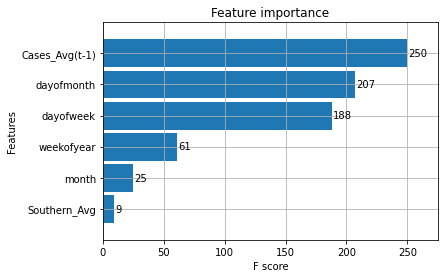

In [84]:
_ = plot_importance(reg, height=0.9)

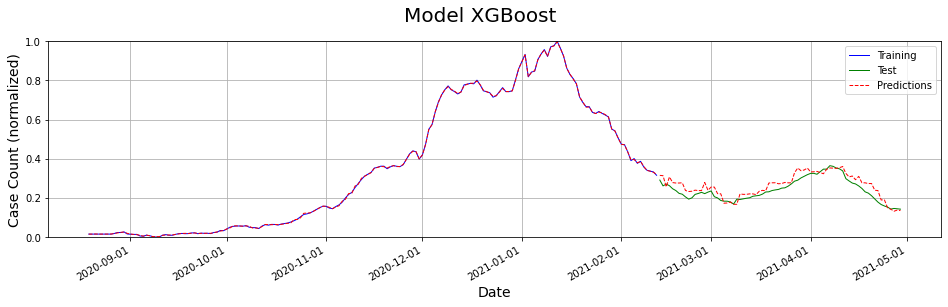

In [85]:
train_predictions = reg.predict(X_train_xg)
test_preds = reg.predict(X_test_xg)

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train_xg, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test_xg, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_predictions, '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds, '--r', linewidth = 1,  label="Predictions")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count (normalized)', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,1])


fig.autofmt_xdate()
fig.suptitle('Model XGBoost', fontsize=20, y=1.00)
fig.show()

In [86]:
# Evalute Model
evaluate_model("XGBoost", y_test_xg, test_preds)

#### Interpretation

* The model predicts the training and test data with better precision when compared to the other models.


* Accounting for seasonality by incorporating multiple date  related variables has resulted in better predictive capabilities of the model

# Validation Results

In [87]:
allModels = glob.glob(os.path.join(MODELS_DIR, "*.json"))
allData = []
for model_file in allModels:
    with open(model_file) as fp:
        model_data = json.load(fp)
        allData.append(model_data)

df_evaluation = pd.DataFrame.from_dict(allData)

In [88]:
df_evaluation.sort_values(by='RMSE', inplace=True)

def highlight_cols(s):
    if s.name in ["RMSE", "MAE", "MAPE"]:
        is_min_max = s == s.min()
    elif s.name in ['Correlation Coeff','R2 Score']:
        is_min_max = s == s.max()
    else:
        is_min_max = [False for _ in range(s.shape[0])]
    return ['background: lightgreen' if cell else '' for cell in is_min_max]

df_evaluation.style.apply(highlight_cols)

,Time,Model,RMSE,MAE,MAPE,Correlation Coeff,R2 Score
0,2021-05-09 05:06:30.923,Persistence,0.011971,0.009323,0.039842,0.978866,0.956400
12,2021-05-09 05:10:05.226,XGBoost,0.030691,0.025727,0.112110,0.934971,0.713416
1,2021-05-09 05:06:31.147,Linear,0.055440,0.043021,0.181891,0.436448,0.064869
7,2021-05-09 05:09:20.863,CNN,0.059789,0.052350,0.254527,0.819074,-0.006686
10,2021-05-09 05:09:56.214,BiGRU,0.063135,0.054450,0.267492,0.823303,-0.122516
2,2021-05-09 05:06:31.232,Polynomial Order: 2,0.064153,0.050865,0.222761,0.445545,-0.252170
4,2021-05-09 05:06:31.271,Polynomial Order: 5,0.065114,0.051647,0.218206,0.358101,-0.289961
3,2021-05-09 05:06:31.251,Polynomial Order: 3,0.065504,0.052028,0.230761,0.437648,-0.305456
9,2021-05-09 05:09:48.304,LSTM,0.070013,0.061548,0.303226,0.777514,-0.380417
6,2021-05-09 05:07:56.250,GAM,0.070088,0.056058,0.247420,0.431046,-0.494586


### Selecting best model


* Since this is a regression problem with a strong underlying linear relationship, RMSE, MAE and MAPE have been used to compare models.


* While persistence model has performed very well, XGBoost is a close second with a low RMSE of 0.03. 


* The R-Squared values of Persistence, XGBoost and CNN are highly positive indicating that the predictor variables have been able to explain the variance in the response variable well.
